In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import tempfile
import os
import shutil
import glob
import xarray as xr
import netCDF4

import shapely
import pyart
# import pandas as pd
import datetime

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D   
from shapely.geometry import Polygon, Point, MultiPoint

from track_summary import TrackSummary
from trackedcell_info import max_cell_area, ds_cell_1time, max_cell_edges, ds_celledges_1time 
from aux_track import backward_propagation, forward_propagation
from cell_bdy import edges_skimage, cell_data, labels_watershed, edges_watershed, idx_win_cell, get_first_scanidx

# import sys
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer
import skimage.measure
import skimage.color

from matplotlib import rcParams, cycler
# For the colorbar
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

import tobac
from tobac.themes import tint


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
class my_dictionary(dict): 
    def __init__(self): 
        self = dict()           
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value 

## TRACK

In [5]:
# - 30dBZ threshold for cells

# - Cell within 100km from radar
# - Cell survives for at least 5 scans
# - Cell is isolated

# - BW propagation
# - FW propagation

# - Edges skimage

In [6]:
# -- No rhohv in July

# - 12 jul 2017 - [:38] [38:] 15h - 18h, 19h - 23h  2 , 24
# - 13 jul 2017 - [:42] [42:]  10,28
# - 17 jul 2017 - [:] 1,4
# - 18 jul 2017 - [:] 0,25
# - 19 jul 2017 - [:25][25:] 2,14
# - 21 jul 2017 - [:] 1,5
# - 26 jul 2017 - [:] 0,13
# - 30 jul 2017 - [:] 0,2

# - 03 ago 2017 - 18h30 - 23h 0,7
# - 04 ago 2017 - 19h - 23h59  0,3
# - 05 ago 2017 - 11h - 21h  0,15
# - 06 ago 2017 - 15h - 21h - 2,23
# - 09 ago 2017 - 01h - 14h, 15h - 18h30, 20h30 - 22h30  
# - 10 ago 2017 - 14h30 - 23h59  0,12
# - 11 ago 2017 - 15h - 23h  1,21
# - 20 ago 2017 - 17h - 21h  1,5
# - 21 ago 2017 - 13h - 15h30  0,1
# - 22 ago 2017 - 15h - 22h  2,5
# - 23 ago 2017 - 11h - 23h59     0,16
# - 24 ago 2017 - 07h - 16h, 18h - 23h59   0,12

In [7]:
filenames = sorted(glob.glob('/home/jessica/tracer/KHGX20170713_*c_grid.nc'))
# print(len(filenames))
filenames = filenames[:42]
# filenames

In [8]:
from copy import deepcopy
# Parameters to track
track_params = deepcopy(tint.objects.default_params)
track_params['GS_ALT'] = 3000
track_params['FIELD_THRESH'] = 30

# Tracks
nc_grid = tint.io.load_cfradial_grids(filenames)
track = tint.make_tracks(nc_grid, 'reflectivity', params=track_params)
# Copy over coordinate data, and fix swapped cell_mask coordinates.
tracks = track.swap_dims({'x':'yf', 'y':'xf'}).rename_dims({'xf':'x', 'yf':'y'})
tracks['x']=nc_grid['x']
tracks['y']=nc_grid['y']
tracks['z']=nc_grid['z']

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12
Writing tracks for scan 13
Writing tracks for scan 14
Writing tracks for scan 15
Writing tracks for scan 16
Writing tracks for scan 17
Writing tracks for scan 18
Writing tracks for scan 19
Writing tracks for scan 20
Writing tracks for scan 21
Writing tracks for scan 22
Writing tracks for scan 23
Writing tracks for scan 24
Writing tracks for scan 25
Writing tracks for scan 26
Writing tracks for scan 27
Writing tracks for scan 28
Writing tracks for scan 29
Writing tracks for scan 30
Writing tracks for scan 31
Writing tracks for scan 32
Writing tracks for scan 33
Writing tracks for scan 34
Writing tracks for scan 35
Writing tracks for scan 36
Writing tra

In [9]:
summary = TrackSummary(tracks)
scan_duration = 5
isolated_min = 0.99

duration_enough = (summary.track_stats['scan_count'] >= scan_duration)
duration_track = summary.track_stats[{'cell':duration_enough}]

isolated_enough = (duration_track['isolated_fraction'] >= isolated_min)
isolated_track = duration_track[{'cell':isolated_enough}]

close_enough = (isolated_track['grid_x_min'] >= 100) & (isolated_track['grid_y_min'] >= 100) & (isolated_track['grid_x_max'] <= 300) & (isolated_track['grid_y_max'] <= 300)
close_track = isolated_track[{'cell': close_enough}]
close_track_id = isolated_track[{'cell': close_enough}].cell.data

In [10]:
cid = 2
scans = close_track.scan_count.sel(cell = close_track_id[cid]).data
cgridx = (tracks.grid_x.sel(cell = str(close_track_id[cid])).data).astype('int')
cgridy = (tracks.grid_y.sel(cell = str(close_track_id[cid])).data).astype('int')

first_time = tracks.cell_time.sel(cell = str(close_track_id[cid])).data[0]
first_scan = get_first_scanidx(filenames, first_time)
nscans = np.arange(first_scan, first_scan + scans)

nlevel = 6
avg_area = int(np.sqrt(close_track.area_max.sel(cell = close_track_id[cid]).data))
min_peak = 10

# Backward propagation
total_data, n_past_scan, new_cgridx, new_cgridy, new_nscans = backward_propagation(filenames, nscans, min_peak, nlevel, avg_area, cgridx, cgridy)

In [11]:
# Forward propagation
min_peak = 10
data_final, future_i, fw_cgridx, fw_cgridy, fw_nscans = forward_propagation(filenames, total_data, new_nscans, min_peak, nlevel, avg_area, new_cgridx, new_cgridy)

dict_cell = my_dictionary() 
dict_keys = ['edges'+str(x) for x in range(len(fw_nscans) + 1)]

In [12]:
# Skimage 
thres = 5
for ntime in np.arange(len(data_final.time.values)):
    edges = edges_skimage(data_final, fw_cgridx, fw_cgridy, ntime, nlevel, thres)
    if np.shape(edges) == np.shape(np.zeros((1,2))):
        continue
    dict_key = dict_keys[ntime]
    radar = pyart.io.read_grid(filenames[fw_nscans[ntime]])
    dict_cell = cell_data(radar, edges, dict_cell, dict_key, ntime, data_final)

35
34
33
36
36
36
35
40
36
48
47
45
46
41
Returning zero


15
15


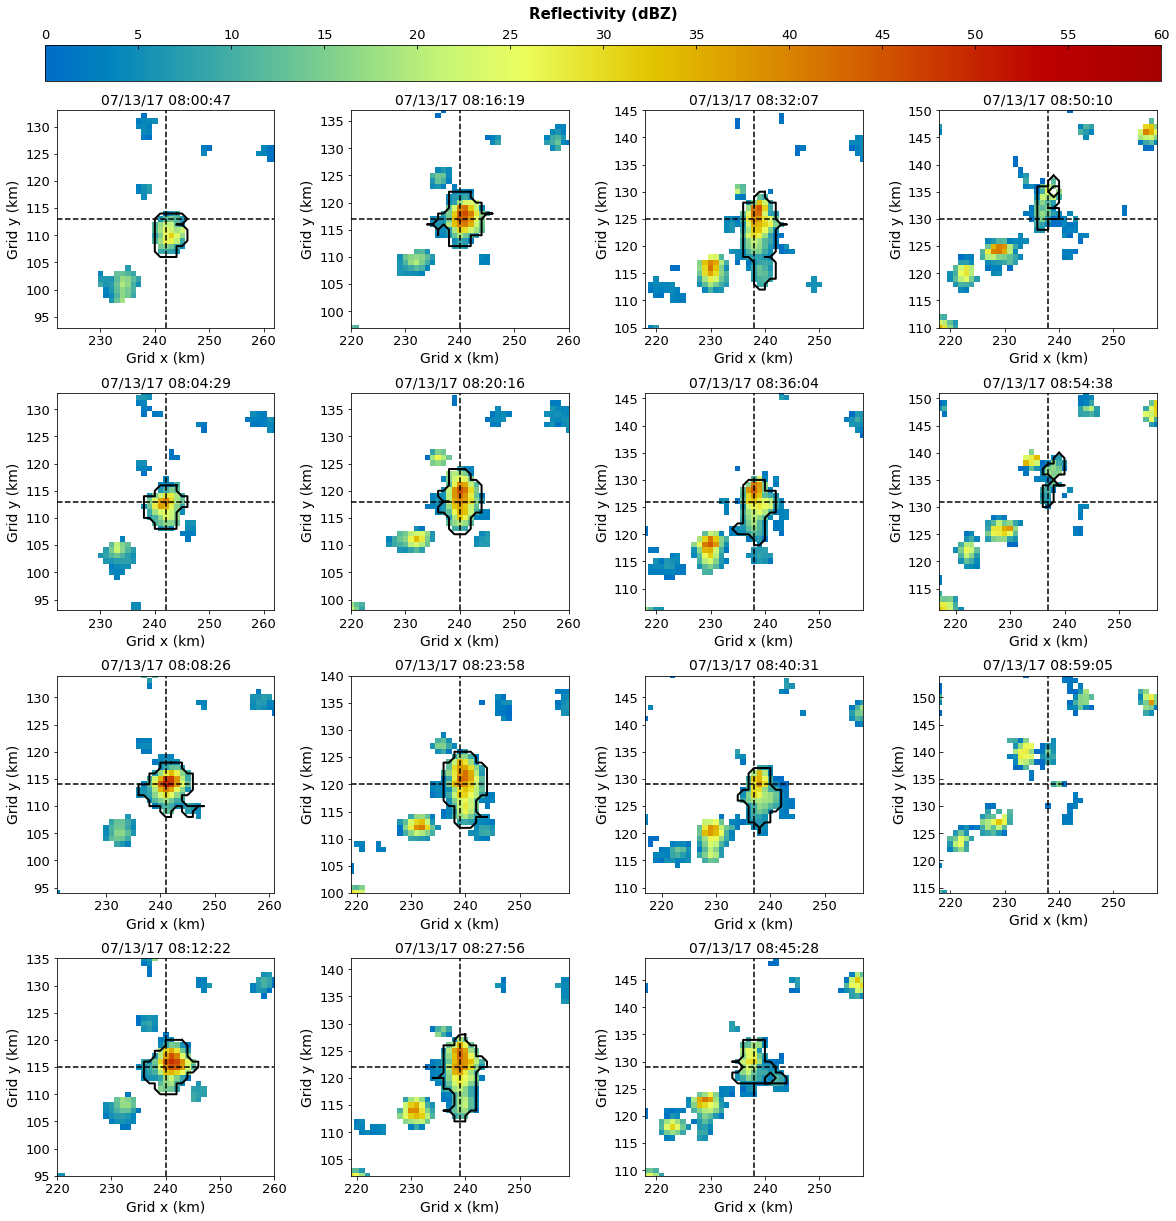

In [13]:
%matplotlib inline
ncol = 4
nrow = int(np.ceil(len(fw_nscans)/4))
##
k = 0
tti = datetime.datetime.utcfromtimestamp(data_final['time'].values[k].tolist()/1e9)
fig = plt.figure(figsize=[ncol*5,nrow*5])
for c in np.arange(ncol):
    for r in np.arange(nrow):
        ix = r*ncol + c
        ax = plt.subplot(nrow,ncol,ix+1)
        cs=plt.imshow(data_final['reflectivity'].values[k,6,:,:], origin = 'lower', 
                      cmap = 'pyart_HomeyerRainbow', vmin = 0, vmax = 60)
        try:
            plt.plot(dict_cell[dict_keys[k]][0][:,1],dict_cell[dict_keys[k]][0][:,0],
                 linewidth = 2, c = 'black')        
        except:
            pass
        zoom = 20
        plt.hlines(fw_cgridy[k],fw_cgridx[k] - zoom,fw_cgridx[k] + zoom, color='black',linestyle='dashed')
        plt.vlines(fw_cgridx[k],fw_cgridy[k] - zoom,fw_cgridy[k] + zoom, color='black',linestyle='dashed')
        plt.ylim(fw_cgridy[k] - zoom, fw_cgridy[k] + zoom)
        plt.ylabel('Grid y (km)',fontsize=14)
        plt.xlim(fw_cgridx[k] - zoom, fw_cgridx[k] + zoom)
        plt.xlabel('Grid x (km)',fontsize=14)
        plt.yticks(fontsize = 13)
        plt.xticks(fontsize = 13)
        tt = datetime.datetime.utcfromtimestamp(data_final['time'].values[k].tolist()/1e9)
        plt.title(tt.strftime("%m/%d/%y %H:%M:%S"),fontsize = 14)
        k=k+1
        if k == (len(fw_nscans)-1):
            print(k)
            break
    if k == (len(fw_nscans)-1):
        print(k)
        break
            
# - Colorbar
cax = fig.add_axes([0.125, 0.89, 0.775, 0.025])
cbar = fig.colorbar(cs, cax = cax, ticks = np.arange(0,65,5), orientation = 'horizontal')
cbar.set_label('Reflectivity (dBZ)', size = 15, fontweight = 'bold', labelpad = 10)
cbar.ax.tick_params(labelsize=13)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
ax.tick_params(direction = 'in')
cbar.ax.tick_params(direction = 'in')

plt.subplots_adjust(top=0.87, bottom=0.13, left=0.13, right=0.9, hspace=0.3, wspace=0.3)

# plt.savefig(tti.strftime("Ref_%m%d%y-%H%M%S_cell")+str(cid)+'.png', dpi = 100, facecolor = 'white', format = 'png', bbox_inches = 'tight')